Downloanding third-party code for resnet model

In [1]:
!wget https://raw.githubusercontent.com/akamaster/pytorch_resnet_cifar10/d1872999394aa0c234e8d855e3c853eb061f7c06/resnet.py


--2020-03-17 20:08:46--  https://raw.githubusercontent.com/akamaster/pytorch_resnet_cifar10/d1872999394aa0c234e8d855e3c853eb061f7c06/resnet.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.192.133, 151.101.128.133, 151.101.64.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.192.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5001 (4,9K) [text/plain]
Saving to: ‘resnet.py’

resnet.py           100%[===================>]   4,88K  --.-KB/s    in 0,002s  

2020-03-17 20:08:47 (1,94 MB/s) - ‘resnet.py’ saved [5001/5001]



Downloading/uploading with google drive

In [2]:
# autorize in google dirve
from google.colab import drive
drive.mount('/content/gdrive')

# download model from google drive
def download_model(source_name, saving_name):
  drive.mount('/content/gdrive')
  !cp "gdrive/My Drive/Colab Notebooks/Study/theasis/cifar_models/{source_name}" {saving_name}

# upload model to google drive
def upload_model(source_name, saving_name):
  drive.mount('/content/gdrive')
  !cp {source_name} "gdrive/My Drive/Colab Notebooks/Study/theasis/cifar_models/{saving_name}" 

def upload_logs():
  drive.mount('/content/gdrive')
  !cp -r logs "gdrive/My Drive/Colab Notebooks/Study/theasis/" 

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


Libs importing

In [2]:
import gc
import os
import datetime

import numpy as np
np.random.seed(42)

import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils as utils
from torch.utils.data import Subset, ConcatDataset, DataLoader

from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorboard.plugins.hparams import api as hp
from sklearn.metrics import accuracy_score

from resnet import resnet20, BasicBlock, _weights_init, resnet32, resnet56, resnet44, ResNet

def resnet7():return ResNet(BasicBlock, [1, 1, 1])

Declaration of utils

In [3]:
class AverageMeter:
  """Class for computing average values
  """    
  def __init__(self):
    """Init class
    """      
    self.sum_ = 0
    self.count = 0
  
  def update(self, val, count=1):
    """Add new value to track
    
    Arguments:
        val {float} -- new value
    
    Keyword Arguments:
        count {int} -- weigth of val (default: {1})
    """      
    self.sum_ += val
    self.count += count

  def average(self):
    """return average value for given values
    """      
    return self.sum_ / self.count

In [4]:
class TensorBoardLogger:
    """Class for logging into TensorBoard
    """    
    def __init__(self, log_dir, dataset, net, experiment_name):
        """Init logger
        
        Arguments:
            log_dir {string} -- log dir
            dataset {string} -- name of dataset
            experiment_name {string} -- name of experiment
        """        
        current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        log_dir_full = os.path.join(log_dir, dataset, net, experiment_name, current_time)
        self.writer = tf.summary.create_file_writer(log_dir_full)
        self.step_ = 0
        
    def log_scalar(self, tag, value, step=None, description=None):
        """Log scalar
        
        Arguments:
            tag {string} -- name of variable to log
            value {float} -- value of variable
        
        Keyword Arguments:
            step {int} -- current epoch number (default: {None})
            description {string} -- [description] (default: {None})
        """        
        if step is None:
            step = self.step_
        with self.writer.as_default():
            tf.summary.scalar(tag, value, step=step, description=description)
            
    def step(self):
        """Increase epoch number by 1
        """        
        self.step_+=1

    def log_hparams(self, hparams):
        """log hparams
        
        Arguments:
            hparams {dict} -- dict to log
        """      
        with self.writer.as_default():
            hp.hparams(hparams)
        

Dataset declaration

In [8]:
batch_size = 64
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

dataset_name = "cifar10"

In [9]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])

# augmentation and normaliztion for training
transform_train = transforms.Compose(
    [
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomCrop(32, 4),
     transforms.ToTensor(),
     normalize
     ])

# only normalization for testing
transform_test = transforms.Compose(
    [
     transforms.ToTensor(),
     normalize
     ])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
valset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_test)
# split trainvalset into val and train
idx = np.arange(len(trainset))
split = int(len(trainset)*0.15)
np.random.seed(42) # set seed to reproduce given set
np.random.shuffle(idx)
train_idx = idx[split:]
val_idx = idx[:split]

trainset = Subset(trainset, train_idx)
valset = Subset(valset, val_idx)


trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2,
                                          pin_memory=True, 
                                          )
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                          shuffle=True, num_workers=2,
                                          pin_memory=True, 
                                          )

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2,
                                         pin_memory=True, )

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


W0317 20:12:35.012532 139635898169152 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


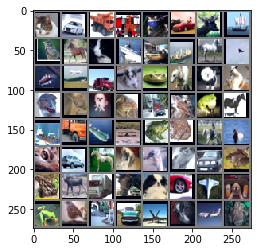

In [10]:
def imshow(img):
    img = img / 4 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [0]:
# check the first index, to check that trainval set splitted correctly
assert val_idx[0]==33553, "invalid val set" 

Training functions definition

In [0]:
def accuracy_minibatch(outputs, labels):
  if isinstance(outputs, torch.Tensor):
    outputs = outputs.cpu().detach().numpy()
  if isinstance(labels, torch.Tensor):
    labels = labels.cpu().detach().numpy()
  
  predict_= np.argmax(outputs, axis=1)
  true_labels_= labels
  micro_acc_score = accuracy_score(predict_, true_labels_)
  return micro_acc_score

In [0]:
def validate(net, testloader, logger=None, compression_f=None, verbose=True, prename="val"):
  """Function for compute metrics on validation set
  
  Arguments:
      net {torch net} -- model
      testloader {DataLoader} -- set to validation
      
  Keyword Arguments:
      logger {TensorBoardLogger} -- logger (default: {None})
      compression_f {function} -- function to preprocess input (default: {None})
      verbose {bool} -- show metrics (default: {True})
      prename {string} -- prename to name of metric (default: {"val"})
  
  Returns:
      [floats] -- scores for computing metrics
  """  
  # change net to evaluation mode
  net.eval()
  ce_loss_avg = AverageMeter()
  accuracy_score_avg = AverageMeter()
  criterion = nn.CrossEntropyLoss()
  
  # evaluate dataset
  for i, data in enumerate(testloader, 0):
    inputs, labels = data
    inputs, labels = inputs.cuda(), labels.cuda()
    current_batch_size = len(labels)

    if compression_f is not None:
      inputs = compression_f(inputs)
    outputs = net(inputs)
    loss = criterion(outputs, labels).cpu().detach().numpy()
    
    micro_acc_score = accuracy_minibatch(outputs, labels)

    accuracy_score_avg.update(micro_acc_score*current_batch_size, current_batch_size)
    ce_loss_avg.update(loss.item()*current_batch_size, current_batch_size)

  accuracy = accuracy_score_avg.average()
  ce_loss = ce_loss_avg.average()
  scores = {"%s_accuracy"%prename:accuracy, "%s_ce_loss"%prename:ce_loss}
  
  # log scores
  for name, score in scores.items():
    if logger:
      logger.log_scalar(name, score)
    if verbose:
      print(name, score)
  
  if verbose:
    print("__________________")
  # change net to training mode
  net.train()
  return scores

In [0]:
def train_classic_approach(
    net, 
    trainloader, 
    testloader, 
    epoches=300,
    compression_f=None, 
    verbose=True, 
    return_best=True,
    logger=None,
    init_lr=0.1,
    patience=10
    ):
  """Training using classic approach
  
  Arguments:
      net {torch model} -- model
      trainloader {DataLoader} -- train set
      testloader {DataLoader} -- test set
  
  Keyword Arguments:
      epoches {int} -- epocs to train (default: {300})
      compression_f {[type]} -- function to preprocess input (default: {None})
      verbose {bool} -- show metrics (default: {True})
      return_best {bool} -- return best model (default: {True})
      logger {TensorBoardLogger} -- logger (default: {None})
      init_lr {float} -- initial learning rate (default: {0.1})
      patience {int} -- patience for scheduler (default: {10})
  
  Returns:
      torch model -- last or best model
  """  
  # change net to training mode
  net.train()
  # use gpu to train
  net.cuda()
  # loss of training
  criterion = nn.CrossEntropyLoss()
  
  optimizer = torch.optim.SGD(
      net.parameters(), 
      lr=init_lr,
      momentum=0.9,
      weight_decay=1e-4)
  scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, threshold=0.001, patience=patience)

  validation_scores = []
  
  os.makedirs("models", exist_ok=True)
  saving_path_template = "models/model_epoch%s.dms"

  for epoch in range(epoches):  # loop over the dataset multiple times
      saving_name = saving_path_template%epoch
      
      loss_avg = AverageMeter()
      accuracy_score_avg = AverageMeter()

      for i, data in enumerate(trainloader, 1):
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = data
          current_batch_size = len(labels)
          if compression_f:
            inputs = compression_f(inputs)
          inputs, labels = inputs.cuda(), labels.cuda()

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = net(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          micro_acc_score = accuracy_minibatch(outputs, labels)

          loss_avg.update(loss.item()*current_batch_size, current_batch_size)
          accuracy_score_avg.update(micro_acc_score*current_batch_size, current_batch_size)

      if verbose:
        print(saving_name)
        print('loss {:.3}'.format(loss_avg.average()))
        print('current lr {:.3e}'.format(optimizer.param_groups[0]['lr']))
        print("__________________")
      
      # clear memory 
      gc.collect()
      torch.cuda.empty_cache()  
      
      validation_score = validate(net, valloader, logger=logger, verbose=verbose, compression_f=compression_f)
      accuracy = validation_score['val_accuracy']
      
      validation_scores.append(accuracy)
      torch.save(net.state_dict(), saving_name)
      
      if logger:
        logger.log_scalar("ce_loss", loss_avg.average())
        logger.log_scalar("accuracy", accuracy_score_avg.average())
        logger.step()
      scheduler.step(loss_avg.average())

  best_epoch = np.argmax(validation_scores)
  if return_best:
    choosen_epoch = best_epoch
  else:
    choosen_epoch = epoch
  if verbose:
    print("choosen epoch:", choosen_epoch, ",", "score:", validation_scores[choosen_epoch])
    print("best epoch:", best_epoch, ",", "score:", validation_scores[best_epoch])
  model_name = saving_path_template%choosen_epoch
  net.load_state_dict(torch.load(model_name))
  return net

In [0]:
for net, name in [
                  (resnet20(), "resnet20_classic.pt"), 
                  (resnet32(), "resnet32_classic.pt"), 
                  (resnet44(), "resnet44_classic.pt"), 
                  (resnet56(), "resnet56_classic.pt")
                  ]:
  logger = TensorBoardLogger("logs", dataset_name, "classic", name)
  net = train_classic_approach(net, trainloader, valloader, logger=logger, return_best=True)
  print("-----------------")
  print(name)
  validate(net, testloader)
  validate(net, valloader)
  validate(net, trainloader)
  print("----------------")
  torch.save(net.state_dict(),name)
  upload_model(name, name)
  upload_logs()

models/model_epoch0.dms
loss 1.72
current lr 1.000e-01
__________________
val_accuracy 0.456
val_ce_loss 1.4952064176559448
__________________
models/model_epoch1.dms
loss 1.24
current lr 1.000e-01
__________________
val_accuracy 0.5396
val_ce_loss 1.3468033034006754
__________________
models/model_epoch2.dms
loss 0.981
current lr 1.000e-01
__________________
val_accuracy 0.6206666666666667
val_ce_loss 1.128271211306254
__________________
models/model_epoch3.dms
loss 0.837
current lr 1.000e-01
__________________
val_accuracy 0.6892
val_ce_loss 0.9277733100255331
__________________
models/model_epoch4.dms
loss 0.727
current lr 1.000e-01
__________________
val_accuracy 0.7190666666666666
val_ce_loss 0.8375049387772878
__________________
models/model_epoch5.dms
loss 0.673
current lr 1.000e-01
__________________
val_accuracy 0.7184
val_ce_loss 0.8933553748766582
__________________
models/model_epoch6.dms
loss 0.624
current lr 1.000e-01
__________________
val_accuracy 0.7661333333333333
val

KeyboardInterrupt: ignored

In [16]:
dataset_name="cifar10"
for i in range(1):
  for net, name in [
                    (resnet7(), "resnet7_classic%s.pt"%i), 
                    ]:
    logger = TensorBoardLogger("logs", dataset_name, "resnet7", name)
    net = train_classic_approach(net, trainloader, valloader, logger=logger, return_best=True, epoches=200, patience=5)
    print("-----------------")
    print(name)
    score_test = validate(net, testloader, prename='test')
    score_val = validate(net, valloader, prename='val')
    score_train=validate(net, trainloader)
    print("----------------")
    hparams = {"experiment_name":name, "teacher":"classic", "dataset":dataset_name}
    for key, value in score_val.items():
      hparams["student/"+key] = value
    for key, value in score_test.items():
      hparams["student/"+key] = value
    for key, value in score_train.items():
      hparams["student/"+key] = val/ue
    
    logger.log_hparams(hparams) 

    torch.save(net.state_dict(),name)
    upload_model(name, name)
    upload_logs()

models/model_epoch0.dms
loss 1.6
current lr 1.000e-01
__________________
val_accuracy 0.5056
val_ce_loss 1.3582966857274374
__________________
models/model_epoch1.dms
loss 1.19
current lr 1.000e-01
__________________
val_accuracy 0.5713333333333334
val_ce_loss 1.245390540377299
__________________
models/model_epoch2.dms
loss 1.03
current lr 1.000e-01
__________________
val_accuracy 0.6309333333333333
val_ce_loss 1.0415907450675965
__________________
models/model_epoch3.dms
loss 0.93
current lr 1.000e-01
__________________
val_accuracy 0.6177333333333334
val_ce_loss 1.0684799689292908
__________________
models/model_epoch4.dms
loss 0.852
current lr 1.000e-01
__________________
val_accuracy 0.6252
val_ce_loss 1.0951176872253419
__________________
models/model_epoch5.dms
loss 0.808
current lr 1.000e-01
__________________
val_accuracy 0.6088
val_ce_loss 1.2401920188268025
__________________
models/model_epoch6.dms
loss 0.766
current lr 1.000e-01
__________________
val_accuracy 0.7053333333